In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pylab as plt
from jupyterthemes import jtplot
import numpy as np
import time
from scipy.optimize import curve_fit
import datetime

jtplot.style(theme='onedork')
# plt.rcParams['figure.figsize'] = (6.0, 6.0)

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
df = pd.read_csv(url, index_col=[0,1]).swaplevel(1,0)
df

,,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
Country/Region,Province/State,,,,,,,,,,,,,,,,,,,,,
Thailand,NaN,15.0000,101.0000,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Japan,NaN,36.0000,138.0000,0,0,0,0,0,0,0,0,...,6,6,6,6,10,10,15,16,19,22
Singapore,NaN,1.2833,103.8333,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nepal,NaN,28.1667,84.2500,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Malaysia,NaN,2.5000,112.5000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Saint Lucia,NaN,13.9094,-60.9789,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Saint Vincent and the Grenadines,NaN,12.9843,-61.2872,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Suriname,NaN,3.9193,-56.0278,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df = df.drop(['Lat', 'Long'], 1).T

In [4]:
df.index = pd.to_datetime(df.index)

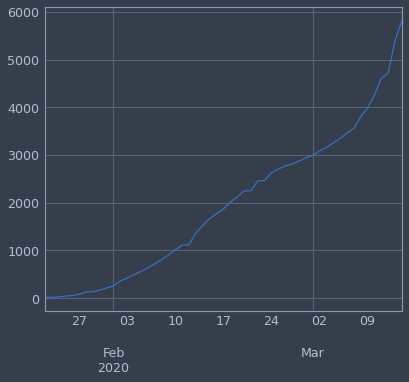

In [5]:
df.T.sum().plot()

In [6]:
len(df.columns)

442

In [7]:
df_exchina = df.drop('China', 1)
len(df_exchina.columns)

/usr/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


409

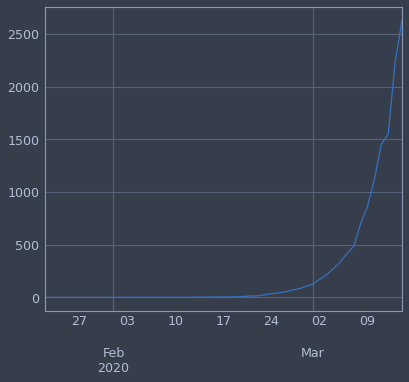

In [8]:
df_exchina.T.sum().plot()

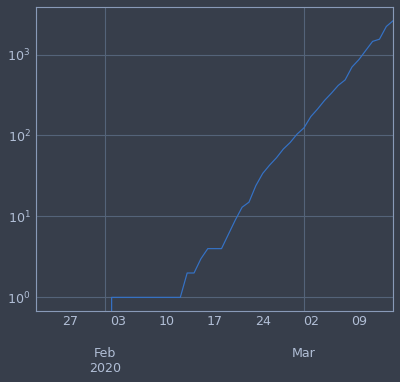

In [9]:
df_exchina.T.sum().plot(logy = True)

0.07 0.15845662041739486 0.1


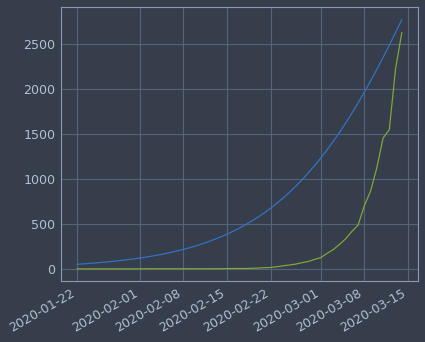

In [10]:


def sigmoid(x, sat, td, velo):
    x = np.float64(x)
    
    td *= 1e10
    td *= 1e9
    
    real_sat = 1e5 * sat
    x = x - td
    x /= 1e14
    return real_sat / (1 + np.exp(-x * velo))

x = df.index.values
sat = 7000 / 1e5
td = (time.time() + 3*24*3600) / 1e10
velo = .1
y = sigmoid(x, sat, td, velo)

print(sat, td, velo)

plt.plot(x, y)
df_exchina.T.sum().plot()
plt.show()

In [11]:


popt, pcov = curve_fit(f = sigmoid, 
                       xdata = x, 
                       ydata = df_exchina.T.sum(), 
                       p0 = (sat, td, velo)
                      )

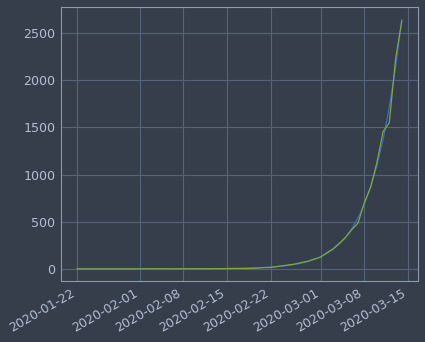

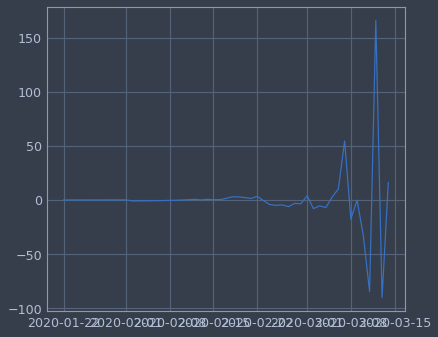

In [12]:
y_fit = sigmoid(x, *list(popt))


plt.plot(x, y_fit)
df_exchina.T.sum().plot()
plt.show()

plt.plot(x, y_fit - df_exchina.T.sum())
plt.show()

In [13]:
t = popt[1] * 1e10
datetime.datetime.fromtimestamp(t)

datetime.datetime(2020, 3, 21, 13, 50, 50, 828403)

In [16]:
popt[0] * 1e5

19220.748772732797

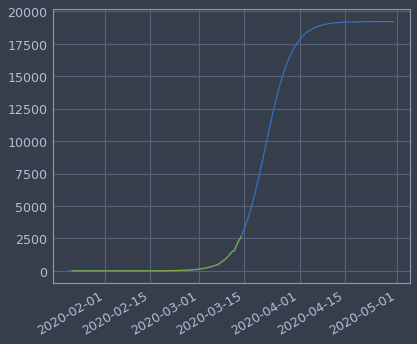

In [15]:
x_extra = np.arange(datetime.datetime(2020,1,21), datetime.datetime(2020,5,1), datetime.timedelta(days=1)).astype('datetime64[ns]')
y_extra = sigmoid(x_extra, *list(popt))

plt.plot(x_extra, y_extra)
df_exchina.T.sum().plot()
plt.show()